# Bitcoin price forecast


In [66]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [67]:
# dataset @ https://finance.yahoo.com/quote/BTC-USD/history/
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727
1,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380
2,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560
3,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059
4,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556


In [68]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2019-01-18,3657.839355
1,2019-01-19,3728.568359
2,2019-01-20,3601.013672
3,2019-01-21,3576.032471
4,2019-01-22,3604.577148


In [69]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [70]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

0   2019-01-18
1   2019-01-19
2   2019-01-20
3   2019-01-21
4   2019-01-22
Name: Date, dtype: datetime64[ns]

In [71]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2019-01-18,3657.839355
2019-01-19,3728.568359
2019-01-20,3601.013672
2019-01-21,3576.032471
2019-01-22,3604.577148


In [72]:
period_in_days = 10
df['Change'] = (df['Close'].shift(-period_in_days) - df['Close']) / df['Close']
df.drop(df.index[-period_in_days:], inplace=True)
df.head()

,Close,Change
Date,,
2019-01-18,3657.839355,-0.051229
2019-01-19,3728.568359,-0.075217
2019-01-20,3601.013672,-0.031889
2019-01-21,3576.032471,-0.033065
2019-01-22,3604.577148,-0.032357


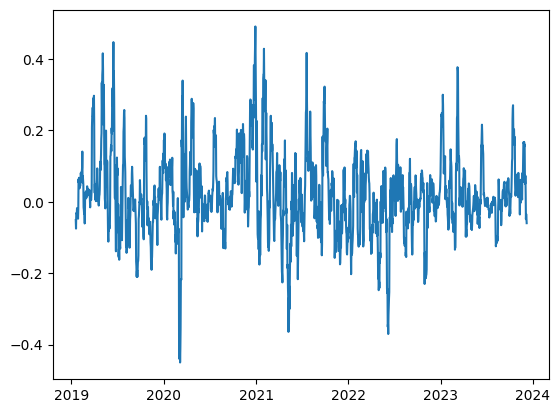

In [73]:
plt.plot(df.index, df['Change'])

In [74]:
change_percentages = list(range(1, 7))
column_changes_names = []
for percentage in change_percentages:
  column_change_name = f'Change_bin_{percentage}'
  df[column_change_name] = (df['Change'] >= percentage/100).astype(int)
  column_changes_names.append(column_change_name)
df.pop('Change')
df.head()

,Close,Change_bin_1,Change_bin_2,Change_bin_3,Change_bin_4,Change_bin_5,Change_bin_6
Date,,,,,,,
2019-01-18,3657.839355,0,0,0,0,0,0
2019-01-19,3728.568359,0,0,0,0,0,0
2019-01-20,3601.013672,0,0,0,0,0,0
2019-01-21,3576.032471,0,0,0,0,0,0
2019-01-22,3604.577148,0,0,0,0,0,0


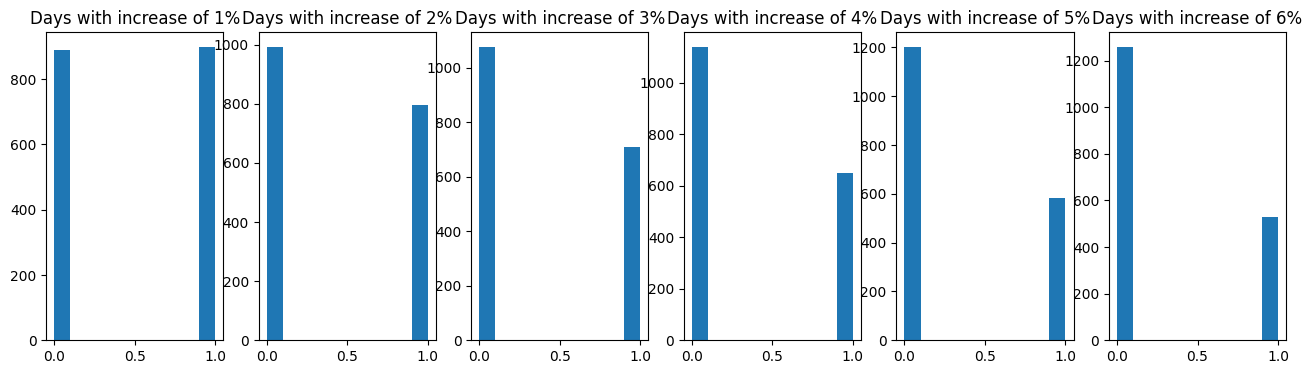

In [75]:
fig, axes = plt.subplots(1, len(change_percentages), figsize=(16, 4))
for i in range(len(change_percentages)):
  ax = axes[i]
  percentage = change_percentages[i]
  ax.hist(df[f'Change_bin_{percentage}'], range=(0, 1))
  ax.set_title(f'Days with increase of {percentage}%')
plt.show()

In [76]:
import numpy as np

# n = number of features
def df_to_windowed_df(dataframe, n=3):
  column_features = dataframe.columns[:-1]
  target = dataframe.loc[:,dataframe.columns[-1]].to_numpy()
  dates = dataframe.index[n-1:].to_numpy()
  Y = target[n-1:]
  feat_amount = len(dataframe.columns) - 1
  input_columns = []
  for i in range(1, feat_amount + 1):
    input_columns.append(dataframe.loc[:,dataframe.columns[-1 * i - 1]].to_numpy())

  X = []
  # X[j] correspond to the j-th feature
  for i in range(feat_amount):
    X.append([])
  for i in range(n):
    for j in range(feat_amount):
      if i == n - 1:
        X[j].append(input_columns[j][i:])
      else:
        X[j].append(input_columns[j][i:i - n + 1])

  ret_df = pd.DataFrame()
  ret_df['Date'] = dates

  for i in range(0, n):
    for j in range(feat_amount):
      ret_df[f'{column_features[j]}-{n-i}'] = X[j][i]

  ret_df['Target'] = Y

  return ret_df

In [77]:
df_set = {}
for col_change_name in column_changes_names:
  df_tmp = df.copy()
  df_tmp = df_tmp[['Close', col_change_name]]
  df_set[col_change_name] = df_tmp
for key in df_set.keys():
  print(df_set[key].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2019-01-18 to 2023-12-08
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1786 non-null   float64
 1   Change_bin_1  1786 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 41.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2019-01-18 to 2023-12-08
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1786 non-null   float64
 1   Change_bin_2  1786 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 41.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2019-01-18 to 2023-12-08
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1786 non-null   float64
 1   Change_bin_3  1786 non-null   int64  


In [78]:
for key in df_set.keys():
  windowed_df = df_to_windowed_df(df_set[key], n=10)
  df_set[key] = windowed_df
  print(df_set[key].head())

        Date     Close-10      Close-9      Close-8      Close-7      Close-6  \
0 2019-01-27  3657.839355  3728.568359  3601.013672  3576.032471  3604.577148   
1 2019-01-28  3728.568359  3601.013672  3576.032471  3604.577148  3585.123047   
2 2019-01-29  3601.013672  3576.032471  3604.577148  3585.123047  3600.865479   
3 2019-01-30  3576.032471  3604.577148  3585.123047  3600.865479  3599.765869   
4 2019-01-31  3604.577148  3585.123047  3600.865479  3599.765869  3602.460449   

       Close-5      Close-4      Close-3      Close-2      Close-1  Target  
0  3585.123047  3600.865479  3599.765869  3602.460449  3583.965820       0  
1  3600.865479  3599.765869  3602.460449  3583.965820  3470.450439       0  
2  3599.765869  3602.460449  3583.965820  3470.450439  3448.116943       1  
3  3602.460449  3583.965820  3470.450439  3448.116943  3486.181641       1  
4  3583.965820  3470.450439  3448.116943  3486.181641  3457.792725       1  
        Date     Close-10      Close-9      Close-8

In [79]:
for key in df_set.keys():
  dates_df = df_set[key]['Date'].copy()
  prices_df = df_set[key].drop(['Date'], axis=1).copy()
  df_set[key] = {'dates': dates_df, 'prices': prices_df}
df_set[list(df_set.keys())[0]]

{'dates': 0      2019-01-27
 1      2019-01-28
 2      2019-01-29
 3      2019-01-30
 4      2019-01-31
           ...    
 1772   2023-12-04
 1773   2023-12-05
 1774   2023-12-06
 1775   2023-12-07
 1776   2023-12-08
 Name: Date, Length: 1777, dtype: datetime64[ns],
 'prices':           Close-10       Close-9       Close-8       Close-7       Close-6  \
 0      3657.839355   3728.568359   3601.013672   3576.032471   3604.577148   
 1      3728.568359   3601.013672   3576.032471   3604.577148   3585.123047   
 2      3601.013672   3576.032471   3604.577148   3585.123047   3600.865479   
 3      3576.032471   3604.577148   3585.123047   3600.865479   3599.765869   
 4      3604.577148   3585.123047   3600.865479   3599.765869   3602.460449   
 ...            ...           ...           ...           ...           ...   
 1772  37796.792969  37479.121094  37254.167969  37831.085938  37858.492188   
 1773  37479.121094  37254.167969  37831.085938  37858.492188  37712.746094   
 1774  3725

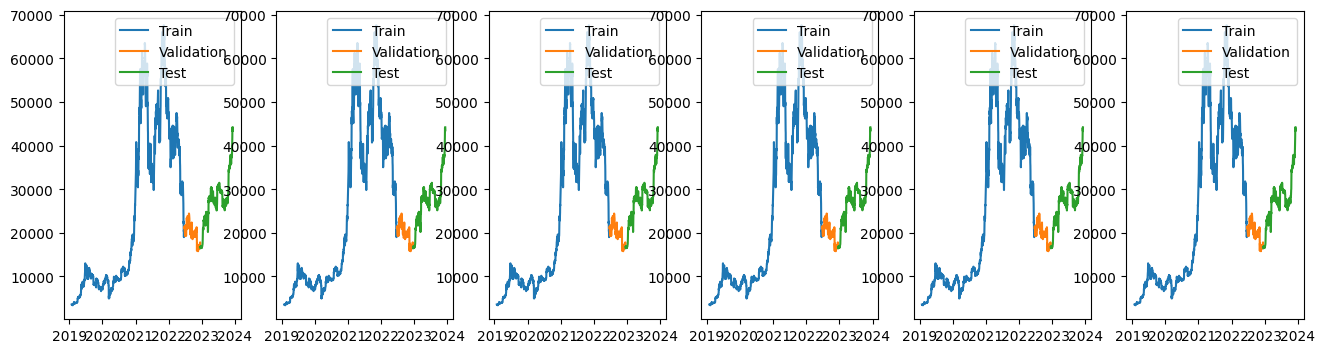

In [80]:
from sklearn.model_selection import train_test_split

train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

df_split_set = {}

fig, axes = plt.subplots(1, len(change_percentages), figsize=(16, 4))
i = 0

for key in df_set.keys():
  dates_df = df_set[key]['dates']
  prices_df = df_set[key]['prices']

  # divide into train, validation and test
  dates_train_val, dates_test = train_test_split(dates_df, test_size=test_percentage, shuffle=False)
  dates_train, dates_val = train_test_split(dates_train_val, test_size=val_percentage/(train_percentage+val_percentage), shuffle=False)

  prices_train_val, prices_test = train_test_split(prices_df, test_size=test_percentage, shuffle=False)
  prices_train, prices_val = train_test_split(prices_train_val, test_size=val_percentage/(train_percentage+val_percentage), shuffle=False)

  df_split_set[key] = {}
  df_split_set[key]['dates'] = {
      'train': dates_train,
      'val': dates_val,
      'test': dates_test
  }
  df_split_set[key]['prices'] = {
      'train': prices_train,
      'val': prices_val,
      'test': prices_test
  }
  ax = axes[i]
  ax.plot(dates_train, prices_train.iloc[:, -2])
  ax.plot(dates_val, prices_val.iloc[:, -2])
  ax.plot(dates_test, prices_test.iloc[:, -2])

  ax.legend(['Train', 'Validation', 'Test'])
  i += 1

In [81]:
for key in df_split_set.keys():
  prices_df = df_split_set[key]['prices']

  prices_train = prices_df['train']
  prices_val = prices_df['val']
  prices_test = prices_df['test']

  scaler = MinMaxScaler()
  # fit scaler on train data
  scaler.fit(prices_train)

  # transform train, validation and test data
  df_split_set[key]['prices']['train'] = scaler.transform(prices_train)
  df_split_set[key]['prices']['val'] = scaler.transform(prices_val)
  df_split_set[key]['prices']['test'] = scaler.transform(prices_test)

In [82]:
for key in df_split_set:
  for split in df_split_set[key]['prices']:
    df_tmp = df_split_set[key]['prices'][split]
    df_split_set[key]['prices'][split] = {
        'X': df_tmp[:,:-1],
        'y': df_tmp[:,-1]
    }

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras import layers, regularizers
from sklearn.utils.class_weight import compute_class_weight

# Suponiendo que y_train es tu conjunto de etiquetas de entrenamiento
# Calcula los pesos de las clases
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
# print(class_weight_dict)

# Modificaciones en la arquitectura del modelo
model = Sequential([
  layers.LSTM(32, input_shape=(10, 1), activation='tanh'),
  layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(.5),
  layers.Dense(1, activation='sigmoid')
  ])

# Ajustes en la tasa de aprendizaje y el decaimiento
lr_schedule = InverseTimeDecay(0.005,
                               decay_steps=5000,
                               decay_rate=0.95,
                               staircase=True)

In [84]:
experiments = list(df_split_set.keys())
len(experiments)

6

In [85]:
experiment_key = experiments[0]
X_train = df_split_set[experiment_key]['prices']['train']['X']
y_train = df_split_set[experiment_key]['prices']['train']['y']
X_val = df_split_set[experiment_key]['prices']['val']['X']
y_val = df_split_set[experiment_key]['prices']['val']['y']

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, class_weight=class_weight_dict)

{0: 1.022203947368421, 1: 0.978740157480315}
Epoch 1/30
39/39 [==============================] - 3s 22ms/step - loss: 0.7094 - accuracy: 0.5286 - val_loss: 0.7070 - val_accuracy: 0.5674
Epoch 2/30
39/39 [==============================] - 0s 10ms/step - loss: 0.7035 - accuracy: 0.5430 - val_loss: 0.7028 - val_accuracy: 0.5674
Epoch 3/30
39/39 [==============================] - 0s 10ms/step - loss: 0.6965 - accuracy: 0.5438 - val_loss: 0.7014 - val_accuracy: 0.5674
Epoch 4/30
39/39 [==============================] - 0s 10ms/step - loss: 0.6966 - accuracy: 0.5278 - val_loss: 0.7033 - val_accuracy: 0.4326
Epoch 5/30
39/39 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.5511 - val_loss: 0.7046 - val_accuracy: 0.4326
Epoch 6/30
39/39 [==============================] - 0s 12ms/step - loss: 0.6917 - accuracy: 0.5479 - val_loss: 0.7052 - val_accuracy: 0.4326
Epoch 7/30
39/39 [==============================] - 0s 12ms/step - loss: 0.6916 - accuracy: 0.5575 - val_loss:

39/39 [==============================] - 1s 3ms/step
[[300 308]
 [226 409]]


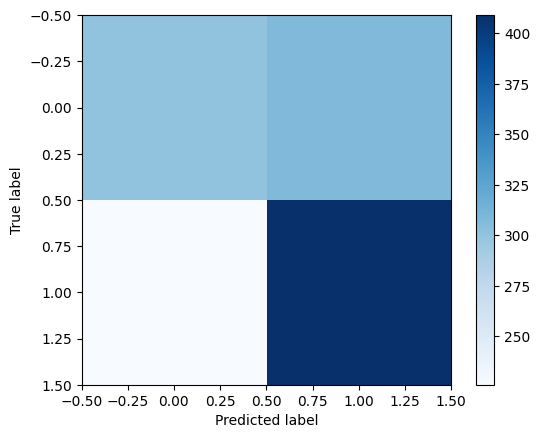

In [86]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_train)

# Threshold para convertir la salida del modelo en una predicción binaria
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred_binary)

# Imprimir la matriz de confusión
print(cm)

# Graficar la matriz de confusión
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [87]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_train)
y_pred = np.round(y_pred)

# confusion matrix
import sklearn.metrics as skm

cm = confusion_matrix(y_train, y_pred)
cr = classification_report(y_train, y_pred)

print("Matriz de Confusión:")
print(cm)
print("\nClassification Report:")
print(cr)

39/39 [==============================] - 0s 3ms/step
Matriz de Confusión:
[[300 308]
 [226 409]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.49      0.53       608
         1.0       0.57      0.64      0.61       635

    accuracy                           0.57      1243
   macro avg       0.57      0.57      0.57      1243
weighted avg       0.57      0.57      0.57      1243

